<div class='alert-block' style='background-color: #007bff; color: #ffffff;'>
    <br>
    <h1 align="center"><b>Part 1：</b> Data Analysis and Baseline model</h1>
    <h5 align="center">Wenbo Sui</h5>
    <br>
</div>

# 1.Data Analysis and Demographic Distribution

In [11]:
import pandas as pd
import numpy as np
import wfdb
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [28]:
# Load metadata
path = '../data/raw/physionet.org/files/ptb-xl/1.0.3/'
df = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')
df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))
scp_df = pd.read_csv(path + 'scp_statements.csv', index_col=0)
diag_scp_df = scp_df[scp_df.diagnostic == 1]

# Aggregate diagnostic superclass
def agg_diag(dic):
    classes = {diag_scp_df.loc[k].diagnostic_class 
               for k in dic.keys() 
               if k in diag_scp_df.index}
    return [c for c in classes if c == c]

df['diagnostic_superclass'] = df.scp_codes.apply(agg_diag)
print(df['diagnostic_superclass'])

ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 21799, dtype: object


In [52]:
# data clean
df_cleaned = df.copy()

# clean strangeage, height and weight 
df_cleaned.loc[df_cleaned['age'] > 150, 'age'] = np.nan 
df_cleaned.loc[(df_cleaned['height'] < 50) | (df_cleaned['height'] > 250), 'height'] = np.nan
df_cleaned.loc[(df_cleaned['weight'] < 5) | (df_cleaned['weight'] > 250), 'weight'] = np.nan

# calculate BMI 
df_cleaned['bmi'] = df_cleaned['weight'] / ((df_cleaned['height'] / 100) ** 2)
df_cleaned.loc[(df_cleaned['bmi'] < 5) | (df_cleaned['bmi'] > 80), 'bmi'] = np.nan

print("\n--- Demographic Descriptive Statistics ---")
cleaned_stats = df_cleaned[['age', 'height', 'weight', 'bmi']].describe()
print(cleaned_stats.loc[['mean', 'std', 'min', 'max']])


--- Demographic Descriptive Statistics ---
            age      height      weight        bmi
mean  59.537245  166.771482   70.995223  25.222046
std   16.758773   10.345488   15.878803   4.631389
min    2.000000   66.000000    5.000000   5.551020
max   89.000000  209.000000  250.000000  59.416025


## Sample and Subject Size

Records: 21799
Patients num: 18869
Average records per patient: 1.16


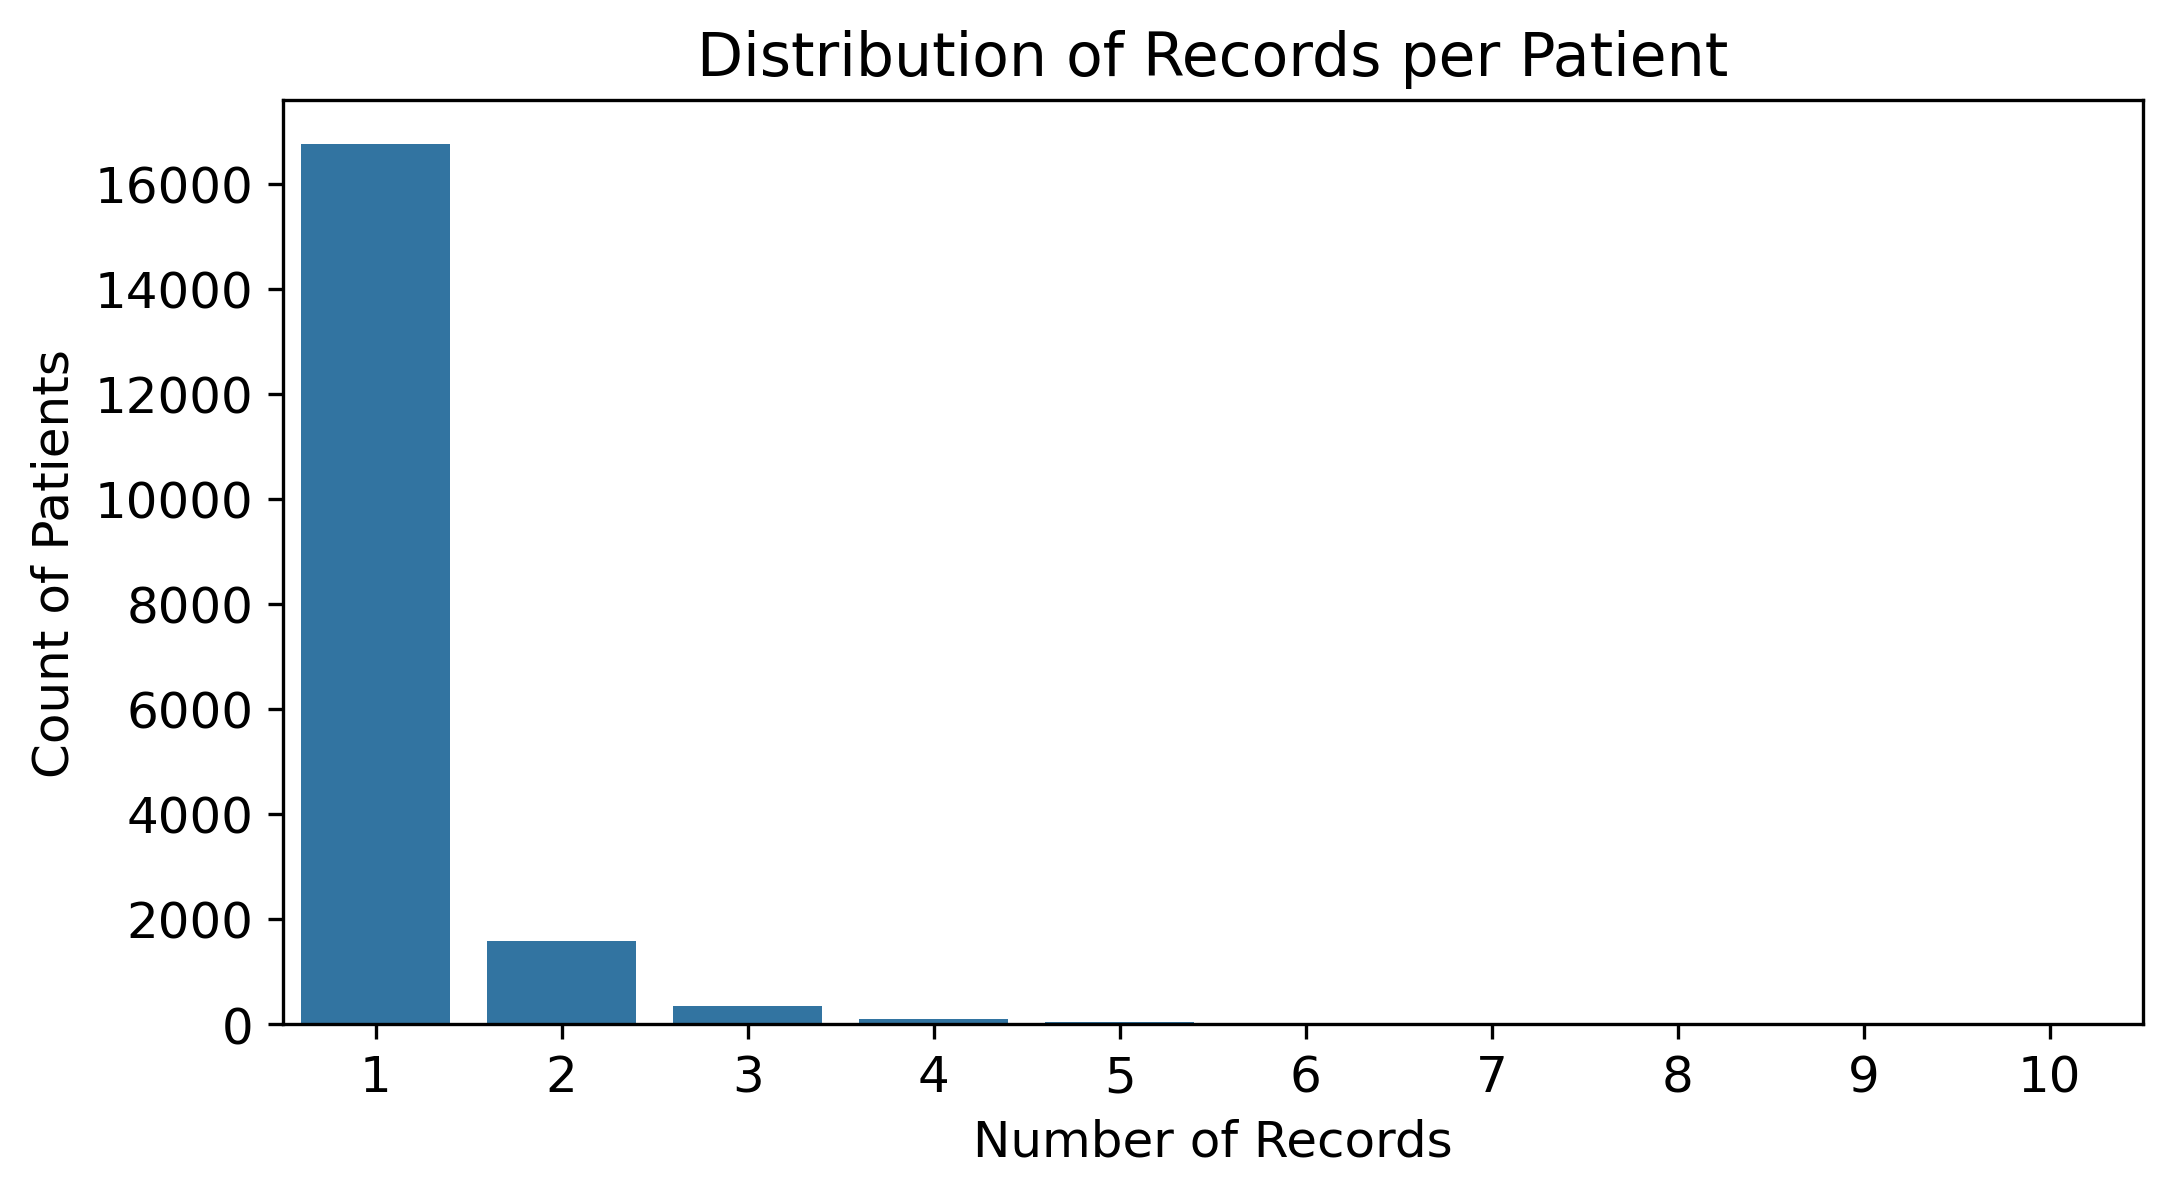

In [49]:

n_records = len(df_cleaned)
n_patients = df_cleaned['patient_id'].nunique()

print(f"Records: {n_records}")
print(f"Patients num: {n_patients}")

# check balance
recs_per_patient = df_cleaned.groupby('patient_id').size()
print(f"Average records per patient: {recs_per_patient.mean():.2f}")

# plot
plt.figure(figsize=(8, 4))
sns.countplot(x=recs_per_patient)
plt.title('Distribution of Records per Patient')
plt.xlabel('Number of Records')
plt.ylabel('Count of Patients')
plt.show()

## Age and gender

In [55]:
print(df[['age', 'height', 'weight']].describe())

                age       height       weight
count  21799.000000  6974.000000  9421.000000
mean      62.769301   166.702323    70.995223
std       32.308813    10.867321    15.878803
min        2.000000     6.000000     5.000000
25%       50.000000   160.000000    60.000000
50%       62.000000   166.000000    70.000000
75%       72.000000   174.000000    80.000000
max      300.000000   209.000000   250.000000



--- Demographic Descriptive Statistics ---
            age      height      weight        bmi
mean  59.537245  166.771482   70.995223  25.215091
std   16.758773   10.345488   15.878803   4.648292
min    2.000000   66.000000    5.000000   1.670620
max   89.000000  209.000000  250.000000  59.416025


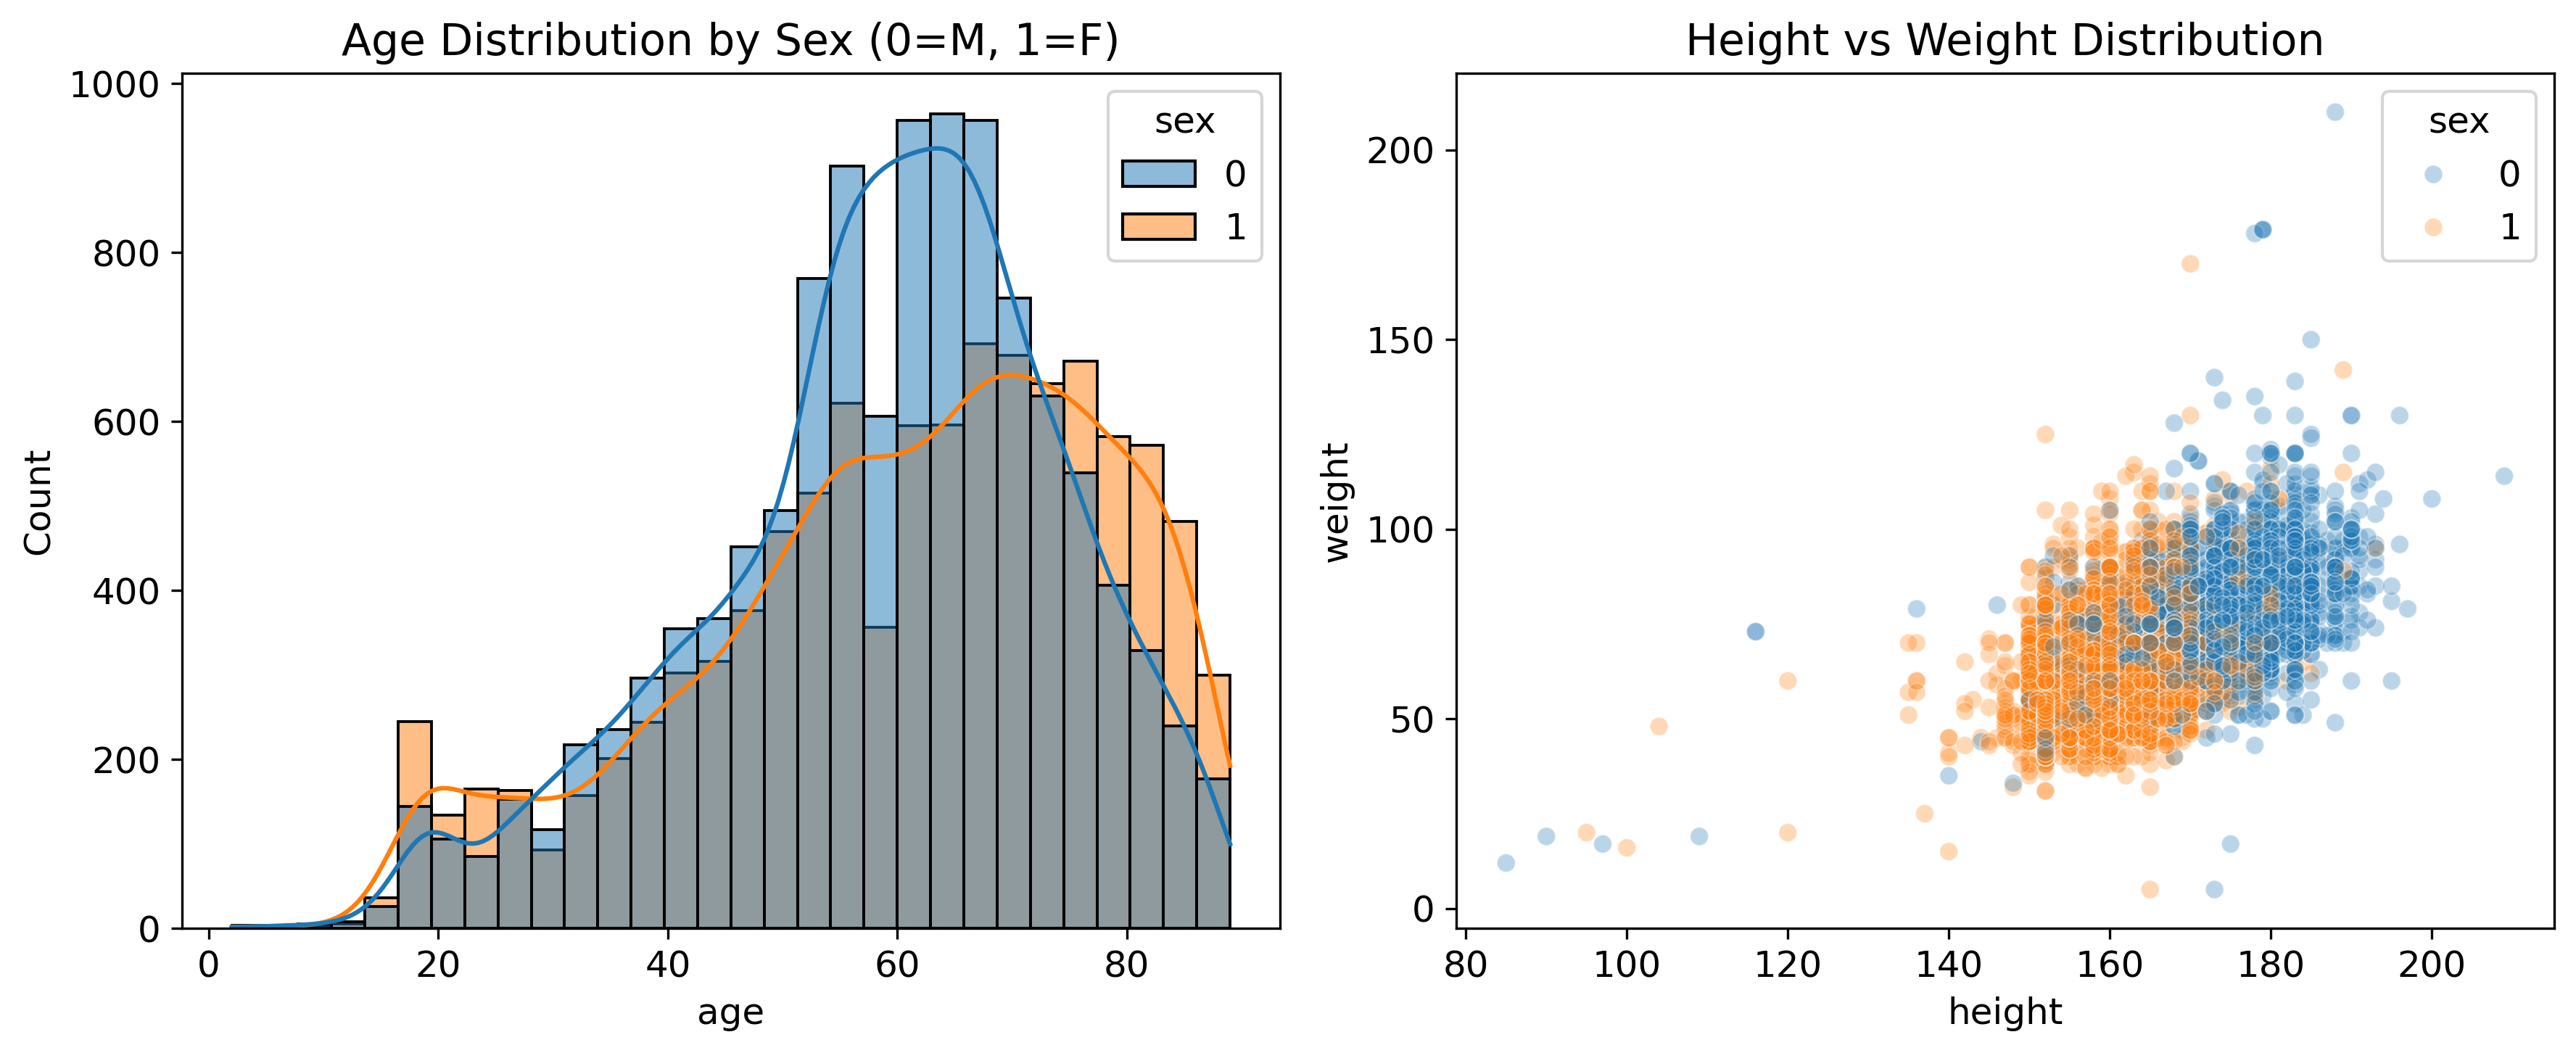

In [53]:
# Data Cleaning
demo_df = df_cleaned[['age', 'sex', 'height', 'weight']].dropna()


df_cleaned['bmi'] = df_cleaned['weight'] / ((df_cleaned['height'] / 100) ** 2)

print("\n--- Demographic Descriptive Statistics ---")
print(df_cleaned[['age', 'height', 'weight', 'bmi']].describe().loc[['mean', 'std', 'min', 'max']])

# Visualization: Age and Sex Distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=df_cleaned, x='age', hue='sex', bins=30, kde=True)
plt.title('Age Distribution by Sex (0=M, 1=F)')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_cleaned, x='height', y='weight', hue='sex', alpha=0.3)
plt.title('Height vs Weight Distribution')

plt.tight_layout()
plt.show()


--- Recording Device Distribution ---
device
CS100    3    6140
CS-12         4048
AT-6 C 5.5    3950
CS-12   E     2878
AT-6     6    2273
AT-60    3     966
AT-6 C 5.8     824
AT-6 C         514
AT-6 C 5.0      80
AT-6 C 5.3      67
Name: count, dtype: int64


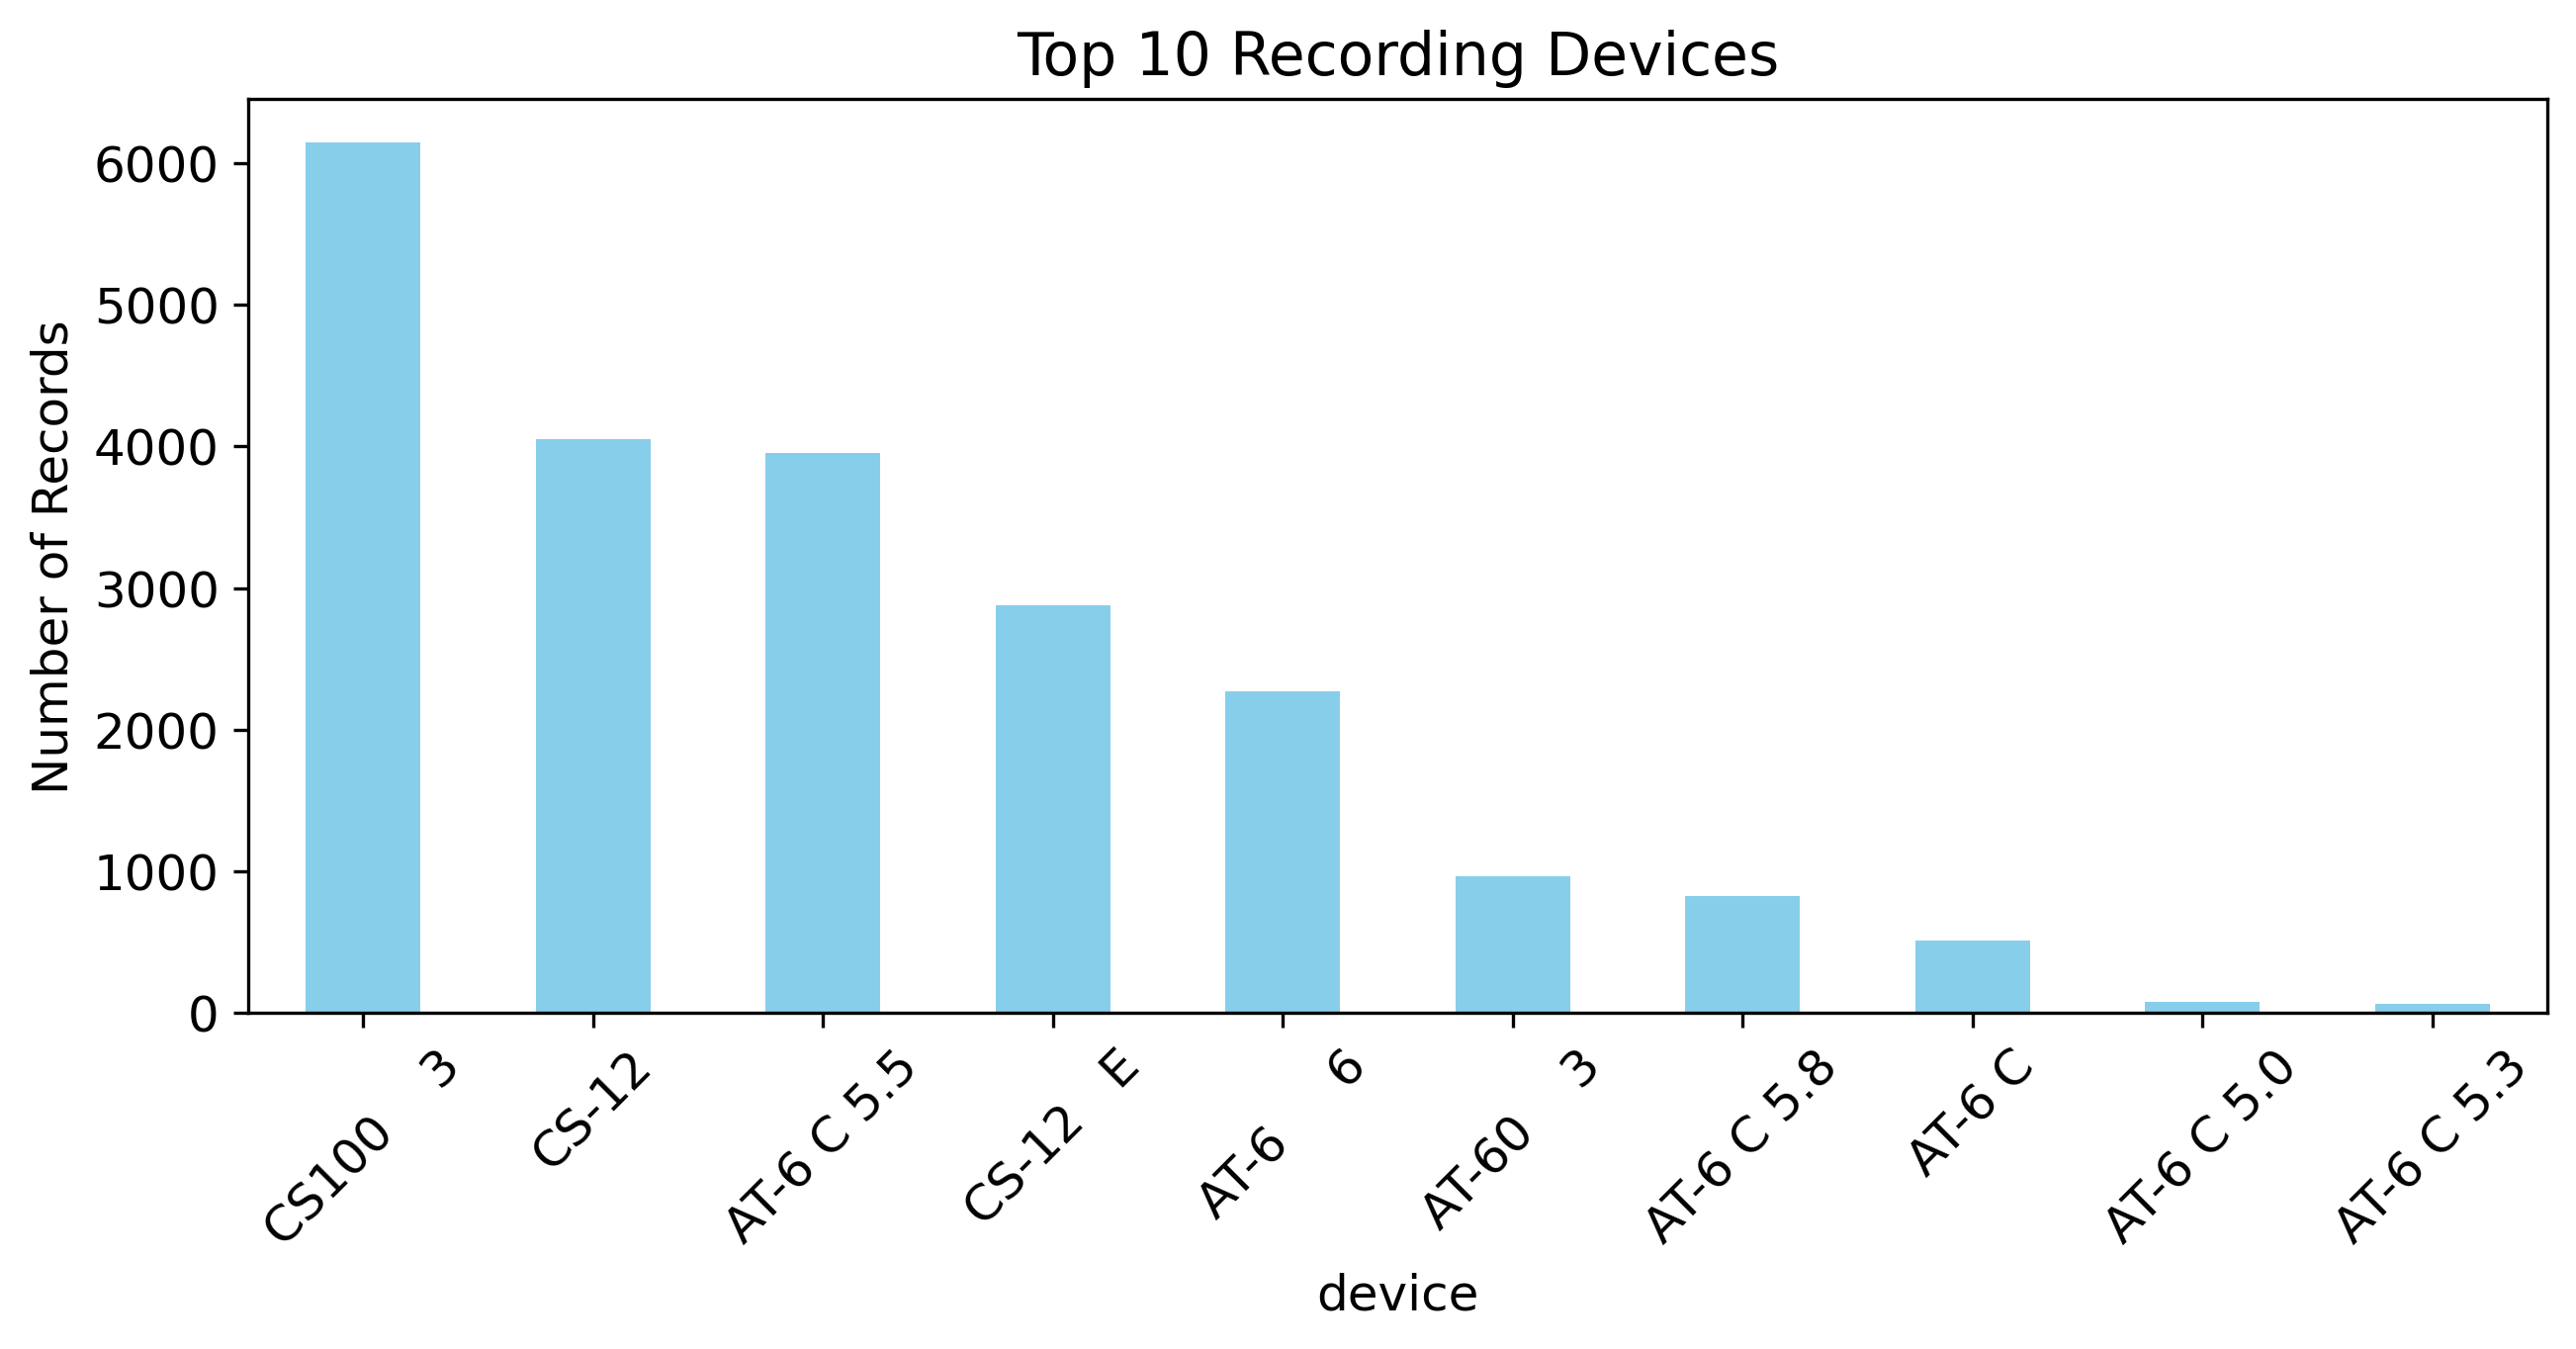


Number of Data Collection Sites: 51


In [37]:
print("\n--- Recording Device Distribution ---")
device_counts = df['device'].value_counts().head(10)
print(device_counts)

plt.figure(figsize=(10, 4))
device_counts.plot(kind='bar', color='skyblue')
plt.title('Top 10 Recording Devices')
plt.ylabel('Number of Records')
plt.xticks(rotation=45)
plt.show()

print(f"\nNumber of Data Collection Sites: {df['site'].nunique()}")

In [35]:
df

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,[NORM]
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,[STTC]
21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,[NORM]
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr,[STTC]


# 2. Demographics and Sampling Parameter Characterization